In [ ]:
# This guide uses machine learning to categorize Iris flowers 
# by species
########################
# 1. Build a model
# 2. Train this model on example data
# 3. Use the model to make predictions about unknown data


In [4]:
# SETUP
# configure Imports
####################
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()

In [5]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


TensorFlow version: 1.14.0
Eager execution: True


In [8]:
# THE IRIS CLASSIFICATION PROBLEM
#################################
# Import and parse the traininig dataset
# Download the dataset
training_dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv'
train_dataset_fp = tf.keras.utils.get_file(
    fname=os.path.basename(training_dataset_url),
    origin=training_dataset_url
)
print('Local copy of the dataset file: {}'.format(
    train_dataset_fp
))

Local copy of the dataset file: /home/george/.keras/datasets/iris_training.csv


In [15]:
# Inspect the data
###################
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [16]:
# column order in CSV file
column_names = ['sepal_length','sepal_width',
                'petal_length','petal_width',
                'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

print('Features: {}'.format(feature_names))
print('Label: {}'.format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [17]:
# 0 -> Iris Setosa
# 1 -> Iris Versicolor
# 2 -> Iris Virginica
class_names = ['Iris setosa','Iris versicolor','Iris virginica']

In [39]:
# Create a (tf.data.Dataset)
################################
# since the dataset is a CSV-formatted text file, use the 
# (make_csv_dataset) function to parse the data into a suitable
# format.
# Since this function generates data for training models, the
# default behaviour is to shuffle the data (shuffle=True),
# (shuffle_buffer_size=10000), and repeat the dataset forever
# (num_epochs=None).
# We also set the (batch_size) parameter

batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)

In [40]:
# The (make_csv_dataset) function returns a (tf.data.Dataset)
# of (features, label) pairs, where (features) is dictionary:-
# {'feature_name':value}
# These Dataset objects are iterable.
# Let's look at a batch of features

features, labels = next(iter(train_dataset))
print(features)


OrderedDict([('sepal_length', <tf.Tensor: id=275, shape=(32,), dtype=float32, numpy=
array([6.7, 6.4, 6.8, 6.6, 5.1, 6.6, 7.2, 4.9, 6. , 5.1, 6.7, 6.3, 6.8,
       5. , 7.7, 5.5, 7.3, 4.4, 6.4, 4.9, 4.9, 4.6, 5.2, 6.3, 5. , 5.7,
       4.6, 6.5, 6.3, 5.8, 4.8, 6.9], dtype=float32)>), ('sepal_width', <tf.Tensor: id=276, shape=(32,), dtype=float32, numpy=
array([3.3, 3.2, 2.8, 3. , 3.7, 2.9, 3. , 3.1, 2.9, 2.5, 3.1, 3.4, 3.2,
       3.5, 3. , 2.4, 2.9, 2.9, 3.1, 2.5, 2.4, 3.2, 2.7, 3.3, 3.4, 3.8,
       3.1, 3. , 2.7, 4. , 3. , 3.2], dtype=float32)>), ('petal_length', <tf.Tensor: id=273, shape=(32,), dtype=float32, numpy=
array([5.7, 4.5, 4.8, 4.4, 1.5, 4.6, 5.8, 1.5, 4.5, 3. , 4.4, 5.6, 5.9,
       1.3, 6.1, 3.8, 6.3, 1.4, 5.5, 4.5, 3.3, 1.4, 3.9, 4.7, 1.5, 1.7,
       1.5, 5.5, 4.9, 1.2, 1.4, 5.7], dtype=float32)>), ('petal_width', <tf.Tensor: id=274, shape=(32,), dtype=float32, numpy=
array([2.1, 1.5, 1.4, 1.4, 0.4, 1.3, 1.6, 0.1, 1.5, 1.1, 1.4, 2.4, 2.3,
       0.3, 2.3, 1.1, 1.8, 0.

In [41]:
# confirm the batch size
for f in features:
    print(len(features[f].numpy()))

32
32
32
32


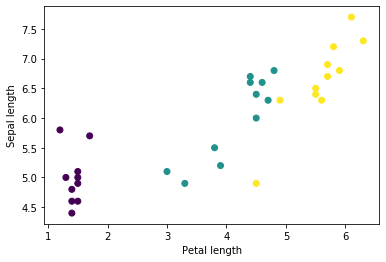

In [42]:
# See some clusters by plotting a few features from the batch
###############################################################
plt.scatter(
    features['petal_length'],
    features['sepal_length'],
    c=labels,
    cmap='viridis'
)
plt.xlabel('Petal length')
plt.ylabel('Sepal length')
plt.show()

In [43]:
# To simplify the model building step, create a function to 
# repackage the features dictionary into a single array
# with shape (batch_size, num_features).
# This function uses the (tf.stack) method which takes values
# from a list of tensors and creates a combined tensor at the 
# specified dimension

def pack_features_vector(features, labels):
    '''Pack the features into a single array'''
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [44]:
# Use the (tf.data.Dataset.map) method to pack the (features) 
# of each (features,label) pair into the training dataset.
train_dataset = train_dataset.map(pack_features_vector)

In [47]:
# The feature element of the (Dataset) are now arrays with
# shape (batch_size, num_features). 
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[6.7 3.3 5.7 2.1]
 [6.4 3.2 4.5 1.5]
 [6.8 2.8 4.8 1.4]
 [6.6 3.  4.4 1.4]
 [5.1 3.7 1.5 0.4]], shape=(5, 4), dtype=float32)


In [48]:
# Select the type of model
##########################
# A model is a relationship between features and the label.
######
# Create a model using Keras
############################
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [51]:
# Using the model
####################
predictions = model(features)
predictions[:5]

<tf.Tensor: id=481, shape=(5, 3), dtype=float32, numpy=
array([[3.5379252 , 2.5882993 , 1.1494532 ],
       [2.6911721 , 1.8851736 , 0.96337473],
       [2.9838514 , 2.1036763 , 1.052392  ],
       [2.6502433 , 1.8339763 , 0.97241503],
       [0.13276246, 0.4292511 , 0.1985964 ]], dtype=float32)>

In [60]:
# COnver the logitsto a probability for each class,
# use (softmax) function
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=548, shape=(5, 3), dtype=float32, numpy=
array([[0.6762901 , 0.26164696, 0.062063  ],
       [0.6156434 , 0.27497202, 0.10938465],
       [0.6411708 , 0.26590014, 0.09292907],
       [0.61392707, 0.27140418, 0.11466879],
       [0.2929822 , 0.39409834, 0.31291944]], dtype=float32)>

In [66]:
# Confirm softmax
tf.reduce_sum(tf.nn.softmax(predictions[:5][3])).numpy()

1.0

In [67]:
# Taking the (tf.argmax) across classes gives us the predicted
# class index.
# But the model has'nt been trained yet, so these aren't 
# predictions
print('Prediction: {}'.format(
    tf.argmax(predictions, axis=1)
))
print('         Labels: {}'.format(labels))

Prediction: [0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0]
         Labels: [2 1 1 1 0 1 2 0 1 1 1 2 2 0 2 1 2 0 2 2 1 0 1 1 0 0 0 2 2 0 0 2]


In [68]:
# TRAIN THE MODEL
##################
# Define the loss and gradient function
####
# Or model will calculate its loss using the
# (tf.keras.losses.SparseCategoricalCrossentropy) function
# which takes the model's class probability predictions and the
# desired label, and returns the average loss across the 
# examples
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [69]:
def loss(model, x, y):
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels)
print('loss test: {}'.format(l))

loss test: 1.7599759101867676


In [71]:
# Use the (tf.GradientTape) context to calculate the gradients
# used to optimize your model.
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [72]:
# Create an optimizer
######################
# An optimizer applies the computed gradients to the model's 
# variables to minimize the loss function.
## #
# This model uses the (tf.keras.optimizers.SGD) that implements
# the stochastic gradient descent (SGD) algorithm.
# The learning_rate sets the step size to take for each 
# iteration down the hill.

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [73]:
# We'll use this to calculate a single optimization step
loss_value, grads = grad(model,features, labels)

print('Step: {}, Initial Loss: {}'.format(
    optimizer.iterations.numpy(),
    loss_value.numpy()
))
optimizer.apply_gradients(zip(grads, model.trainable_variables))

print('Step: {},          Loss: {}'.format(
    optimizer.iterations.numpy(),
    loss(model, features, labels).numpy()
))

Step: 0, Initial Loss: 1.7599759101867676
Step: 1,          Loss: 1.6822283267974854


In [87]:
# Training Loop
################
# 1. Iterate each epoch. (epoch is one pass through the dataset)
# 2. Within an epoch, iterate over each example in the training
# (Dataset) grabbing its features (x) and label (y)
# 3. Using the example's features, make a prediction and 
# compare it with the label.
# Measure the inaccuracy of the prediction and use that to 
# calculate the model's loss and gradients
# 4. Use an (optimizer) to update the model's variables
# 5. Keep track of some stats for visualization
# 6. Repeat for each epoch

####################
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.682, Accuracy: 0.000%
Epoch 050: Loss: 1.682, Accuracy: 35.000%
Epoch 100: Loss: 1.682, Accuracy: 35.000%
Epoch 150: Loss: 1.682, Accuracy: 35.000%
Epoch 200: Loss: 1.682, Accuracy: 35.000%


In [ ]:
# Visualize the loss function over time
fig, axes = plt.subplots(2, sharex=True, figsize=(12,8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel('Loss',fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


In [78]:
# Evaluate the model's effectiveness
##########

In [79]:
# Setup the test dataset
#####################
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)


In [81]:
# Evaluate the model on the test dataset
#####
test_accuracy = tf.keras.metrics.Accuracy()
for (x,y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)
                  
                  
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 0.000%


In [82]:
# We can see on the batch, eg. the model is usually correct
tf.stack([y, prediction], axis=1)

<tf.Tensor: id=1178, shape=(30, 2), dtype=int32, numpy=
array([[1, 0],
       [2, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 0],
       [2, 0],
       [2, 0],
       [0, 1],
       [2, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [2, 0],
       [0, 1],
       [1, 0],
       [2, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [2, 0],
       [1, 0]], dtype=int32)>

In [83]:
# Use the trained model to make predictions
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)
for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))


Example 0 prediction: Iris versicolor (35.6%)
Example 1 prediction: Iris setosa (54.7%)
Example 2 prediction: Iris setosa (61.6%)
